In [17]:
import pandas as pd
import simstpy as sim
import numpy as np
import scipy as sp
from anndata import AnnData
from muon import atac as ac
import scanpy as sc

In [2]:
df_spatial = sim.spatial.read_pattern("human_DLPFC_151508")
df_spatial.head()

,x,y,spatial_cluster
AAACAAGTATCTCCCA-1,9171,8586,L3
AAACAATCTACTAGCA-1,5127,2944,L1
AAACACCAATAACTGC-1,3454,9646,WM
AAACAGAGCGACTCCT-1,8634,4273,L1
AAACAGCTTTCAGAAG-1,2772,7728,L6


In [3]:
group_name = "spatial_cluster"
n_da_peaks = 1000
n_non_da_peaks = 10000
n_unique_fragments = 10000

In [4]:
df_spatial[group_name] = df_spatial[group_name].astype(str)
n_groups = len(df_spatial[group_name].unique())

In [5]:
gamma_dist = sp.stats.gamma(*(0.6227306182997188, 0, 0.24285327175872837))

In [6]:
da_peaks = gamma_dist.rvs(n_da_peaks)
non_da_peaks = gamma_dist.rvs(n_non_da_peaks)

In [7]:
# for SVGs, we split the genes into serveral groups
da_peaks_list = np.array_split(range(n_da_peaks), n_groups)
all_cell_ids, accessibility = [], np.empty((0, n_da_peaks + n_non_da_peaks))

In [8]:
for i, cell_group in enumerate(df_spatial[group_name].unique()):
        cell_ids = df_spatial.index.values[df_spatial[group_name].values == cell_group]
        all_cell_ids += list(cell_ids)

        # randomly select a number of DE genes
        da_peaks_idx = da_peaks_list[i]

        # generate DE factor from log-normal distribution
        _da_peaks = da_peaks.copy()
        _da_peaks[da_peaks_idx] = _da_peaks[da_peaks_idx] * 8

        peak_acc = np.concatenate((_da_peaks, non_da_peaks))

        peak_acc = peak_acc / np.sum(peak_acc)
        peak_acc = np.expand_dims(peak_acc, axis=0)

        _lib_size = np.random.poisson(lam=10000, size=len(cell_ids))
        _lib_size = np.expand_dims(_lib_size, axis=1)
        mat = np.matmul(_lib_size, peak_acc)   
        accessibility = np.concatenate((accessibility, mat), axis=0) 

In [9]:
accessibility

array([[0.23322836, 0.6757534 , 2.00268949, ..., 0.09244019, 0.63358895,
        0.45669266],
       [0.23409677, 0.67826954, 2.01014642, ..., 0.09278439, 0.63594809,
        0.45839314],
       [0.23475395, 0.68017364, 2.0157895 , ..., 0.09304486, 0.63773339,
        0.45967998],
       ...,
       [0.02910674, 0.08433358, 0.24993432, ..., 0.0922918 , 0.63257184,
        0.45595953],
       [0.02854918, 0.08271809, 0.24514659, ..., 0.09052386, 0.62045433,
        0.44722519],
       [0.02919386, 0.084586  , 0.2506824 , ..., 0.09256804, 0.6344652 ,
        0.45732427]])

In [10]:
# find the maximum value of each row
max_values = np.max(accessibility, axis=1)

# divide each row by its corresponding maximum value
res = accessibility / max_values[:, np.newaxis]

counts = np.random.binomial(n=1, p=res)
counts = sp.sparse.csr_matrix(counts)
adata = AnnData(counts, dtype=np.float32)

In [11]:
adata

AnnData object with n_obs × n_vars = 4381 × 11000

In [12]:
ac.preproc.tfidf(adata)

/home/rs619065/miniconda3/envs/svg/lib/python3.9/site-packages/muon/_atac/preproc.py:106: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.asarray(adata.shape[0] / adata.X.sum(axis=0)).reshape(-1)


In [13]:
ac.tools.lsi(adata)

In [14]:
sc.pp.neighbors(adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [15]:
sc.tl.umap(adata, spread=1.5, min_dist=.5, random_state=20)

/home/rs619065/miniconda3/envs/svg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


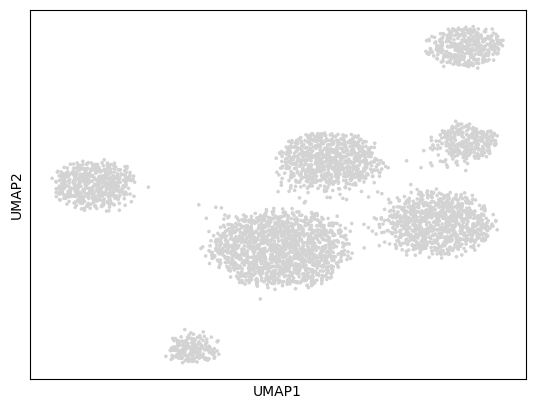

In [16]:
ac.pl.umap(adata, use_raw=False)